# Setup


In [11]:
# Import packages
import cv2
import matplotlib.pyplot as plt
import numpy as np
import easyocr as eor
import pandas as pd

In [2]:
# Read images
image1 = cv2.imread('Images/Image6.jpg') # Russian Taxi at Angle and Some Distance
image2 = cv2.imread('Images/Image7.jpg') # Two Russian Plates with Telephoto Lens
image3 = cv2.imread('Images/Image4.jpg') # Ontario Plate
source = list([image1, image2, image3])
# https://www.geeksforgeeks.org/how-to-fix-valueerror-setting-an-array-element-with-a-sequence/
source = np.array(source, dtype = list)

# Define placeholders
gray = np.array([0, 1, 2], dtype = list)
plates = np.array(list(range(3)), dtype = list)
plateszoom = np.array(list(range(3)), dtype = list)

# Convert to Grayscale
for i in range(len(source)):
    gray[i] = cv2.cvtColor(source[i], cv2.COLOR_BGR2GRAY)

# # Load Classifier
rusPlateReader = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_license_plate_rus_16stages.xml')
rusPlateFinder = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml')

# Detect Plates

In [3]:
# Detect Plates
# https://github.com/kennethleungty/Car-Plate-Detection-OpenCV-TesseractOCR/blob/main/Car%20Plate%20Detection%20with%20OpenCV%20and%20TesseractOCR.ipynb
def CarplateDetect(image):
    # Color rectangle overlay on grayscale image plate detection area
    carplate_overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    carplate_rects = rusPlateFinder.detectMultiScale(carplate_overlay,
                                                     scaleFactor = 1.1,
                                                     minNeighbors = 5) 
    # carplate_img = 0

    for x, y, w, h in carplate_rects:
        cv2.rectangle(carplate_overlay,
                      (x, y),
                      (x + w, y + h),
                      (255, 0, 0),
                      25) 
        
    # for x, y, w, h in carplate_rects:
    #     carplate_img = carplate_overlay[y + 15: y + h - 10,
    #                          x + 15: x + w - 20] 


    return carplate_overlay

In [4]:
carplate_overlay = image2.copy()
carplate_rects = rusPlateFinder.detectMultiScale(carplate_overlay,
                                                    scaleFactor = 1.1,
                                                    minNeighbors = 5) 

for x, y, w, h in carplate_rects:
    cv2.rectangle(carplate_overlay,
                    (x, y),
                    (x + w, y + h),
                    (255, 0, 0),
                    25)

# Zoom on Plates

## Works

In [5]:
def PlateZoom(image):
    carplate_overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    carplate_rects = rusPlateFinder.detectMultiScale(carplate_overlay,
                                                     scaleFactor = 1.1,
                                                     minNeighbors = 5)
    for x, y, w, h in carplate_rects:
        carplate_img = carplate_overlay[y + 15: y + h - 10,
                             x + 15: x + w - 20]
    return carplate_img

In [6]:
def carplate_extract(image):
    
    carplate_rects = rusPlateFinder.detectMultiScale(image,scaleFactor=1.1, minNeighbors=5) 

    plates_x = min(carplate_rects[:, 0])
    plates_y = min(carplate_rects[:, 1])
    plates_h = max(carplate_rects[:, 3])
    plates_w = max(carplate_rects[:, 2])
    carplate_img = image[plates_y : plates_y + plates_h, plates_x : plates_x + plates_w]

    return carplate_img

In [6]:
def SemiZoom(image, overlay):
    image = overlay[image[1]:image[1]+image[3],
                    image[0]:image[0]+image[2]]
    return image

### Extraction

In [7]:
# First Image Extracted
plates_0 = CarplateDetect(gray[0])
plateszoom_0 = PlateZoom(gray[0])

# Second Image Extracted
# Lots of room to improve code here
carplate_rects = rusPlateFinder.detectMultiScale(gray[1],
                                                     scaleFactor = 1.1,
                                                     minNeighbors = 5)
carplate_overlay = cv2.cvtColor(gray[1].copy(), cv2.COLOR_GRAY2BGR)
carplate_rects_0 = carplate_rects[0]
carplate_rects_1 = carplate_rects[1]
plates_1 = CarplateDetect(gray[1])
plateszoom_1 = SemiZoom(carplate_rects_0, carplate_overlay)
plateszoom_2 = SemiZoom(carplate_rects_1, carplate_overlay)

# Third Image
# Non-Russian plate not identified and therefore not extracted
plates_2 = CarplateDetect(gray[2])

In [8]:
def calculate_slope(point1, point2):
    # Calculate the slope between two points
    delta_y = point2[1] - point1[1]
    delta_x = point2[0] - point1[0]
    
    # Avoid division by zero
    if delta_x != 0:
        slope = delta_y / delta_x
    else:
        slope = np.inf
    
    return slope

def calculate_rotation_angle(point1, point2):
    # Calculate the angle between the line connecting the two points and the horizontal axis
    delta_y = point2[1] - point1[1]
    delta_x = point2[0] - point1[0]
    
    # Calculate the angle using arctan
    angle = np.arctan(delta_y, delta_x)
    
    return angle

def rotate_image(image, angle, center):
    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Perform the rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    
    return rotated_image

def RotationProcess(image, point1, point2):
    slope = calculate_slope(point1, point2)
    angle = np.arctan(slope)
    angle = np.degrees(angle)
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotated_image = rotate_image(image, angle, center)
    return rotated_image

In [165]:
rotated_plate_0 = RotationProcess(plateszoom_0, (30, 156), (441, 195))
rotated_plate_1 = RotationProcess(plateszoom_1, (10.2, 74.3), (234.7, 71.2))
rotated_plate_2 = RotationProcess(plateszoom_2, (10, 75), (234, 72))

In [45]:
def Gaussian(item, kernel):
    blur = cv2.GaussianBlur(item, (kernel, kernel), 10)
    return blur

In [173]:
reader = eor.Reader(['ru'])
rotated_plate_0_g = Gaussian(rotated_plate_0, 5)
result_0 = reader.readtext(rotated_plate_0_g, paragraph = 'False')
result_frame_0 = pd.DataFrame(result_0)
rotated_plate_1_g = Gaussian(rotated_plate_1, 5)
result_1 = reader.readtext(rotated_plate_1_g, paragraph = 'False')
result_frame_1 = pd.DataFrame(result_1)
rotated_plate_2_g = Gaussian(rotated_plate_2, 3)
result_2 = reader.readtext(rotated_plate_2_g, paragraph = 'False')
result_frame_2 = pd.DataFrame(result_2)
print(result_frame_2[1])

In [174]:
print(result_frame_0[1])
print(result_frame_1[1])

0    [Т413СА77 905
Name: 1, dtype: object
0    Е521кх99
Name: 1, dtype: object


## Experimenting

## Text Reading

In [175]:
rotated_plate_2_g = Gaussian(rotated_plate_2, 3)
result_2 = reader.readtext(rotated_plate_2_g, paragraph = 'False')
result_frame_2 = pd.DataFrame(result_2)
print(result_frame_2[1])

0    ВАО6АА
Name: 1, dtype: object


In [176]:
rotated_plate_2_g = Gaussian(rotated_plate_2, 5)
result_2 = reader.readtext(rotated_plate_2_g, paragraph = 'False')
result_frame_2 = pd.DataFrame(result_2)
print(result_frame_2[1])

0    В1О644
Name: 1, dtype: object


In [169]:
rotated_plate_0_g = Gaussian(rotated_plate_0, 3)
rotated_plate_1_g = Gaussian(rotated_plate_1, 3)
rotated_plate_2_g = Gaussian(rotated_plate_2, 3)

# https://forum.opencv.org/t/how-to-find-out-if-my-image-type-is-cv-8uc1-in-opencv-python-and-what-are-the-other-possible-images-types/10365
rotated_plate_0_g_1 = cv2.cvtColor(rotated_plate_0_g, cv2.COLOR_BGR2GRAY)
rotated_plate_1_g_1 = cv2.cvtColor(rotated_plate_1_g, cv2.COLOR_BGR2GRAY)
rotated_plate_2_g_1 = cv2.cvtColor(rotated_plate_2_g, cv2.COLOR_BGR2GRAY)

In [148]:
rotated_plate_0_g_1 = np.asarray(rotated_plate_0_g_1, dtype = np.uint8)

In [151]:
rotated_plate_0_g_e = cv2.dilate(rotated_plate_0_g_1, 3, iterations = 1)

error: OpenCV(4.8.1) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/morph.simd.hpp:649: error: (-215:Assertion failed) _kernel.type() == CV_8U in function 'MorphFilter'


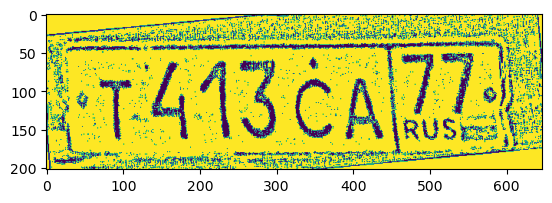

In [116]:
plt.imshow(rotated_plate_0_g_thresh)

In [172]:
result_0_g_t = reader.readtext(rotated_plate_0_g_thresh, paragraph = 'False')
result_frame_0_g_t = pd.DataFrame(result_0_g_t)
result_1_g_t = reader.readtext(rotated_plate_1_g_thresh, paragraph = 'False')
result_frame_1_g_t = pd.DataFrame(result_1_g_t)
result_2_g_t = reader.readtext(rotated_plate_2_g_thresh, paragraph = 'False')
result_frame_2_g_t = pd.DataFrame(result_2_g_t)
print(result_frame_0_g_t[1])
print(result_frame_1_g_t[1])
print(result_frame_2_g_t[1])

0    1 413 СА71:
Name: 1, dtype: object
0    Е521кх 99
Name: 1, dtype: object
0    106 4 4
Name: 1, dtype: object


In [170]:
# https://forum.opencv.org/t/how-to-find-out-if-my-image-type-is-cv-8uc1-in-opencv-python-and-what-are-the-other-possible-images-types/10365
rotated_plate_0_g_1 = cv2.cvtColor(rotated_plate_0_g, cv2.COLOR_BGR2GRAY)
rotated_plate_1_g_1 = cv2.cvtColor(rotated_plate_1_g, cv2.COLOR_BGR2GRAY)
rotated_plate_2_g_1 = cv2.cvtColor(rotated_plate_2_g, cv2.COLOR_BGR2GRAY)
# rotated_plate_0 = cv2.cvtColor(rotated_plate_0, cv2.COLOR_BGR2GRAY)
# rotated_plate_1 = cv2.cvtColor(rotated_plate_1, cv2.COLOR_BGR2GRAY)
# rotated_plate_2 = cv2.cvtColor(rotated_plate_2, cv2.COLOR_BGR2GRAY)

# rotated_plate_0_g_thresh = cv2.threshold(rotated_plate_0, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# rotated_plate_1_g_thresh = cv2.threshold(rotated_plate_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# rotated_plate_2_g_thresh = cv2.threshold(rotated_plate_2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

rotated_plate_0_g_thresh = cv2.threshold(rotated_plate_0_g_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
rotated_plate_1_g_thresh = cv2.threshold(rotated_plate_1_g_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
rotated_plate_2_g_thresh = cv2.threshold(rotated_plate_2_g_1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# rotated_plate_0_g_thresh = cv2.adaptiveThreshold(rotated_plate_0_g_1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)
# rotated_plate_1_g_thresh = cv2.adaptiveThreshold(rotated_plate_1_g_1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -1)
# rotated_plate_2_g_thresh = cv2.adaptiveThreshold(rotated_plate_2_g_1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, -1)

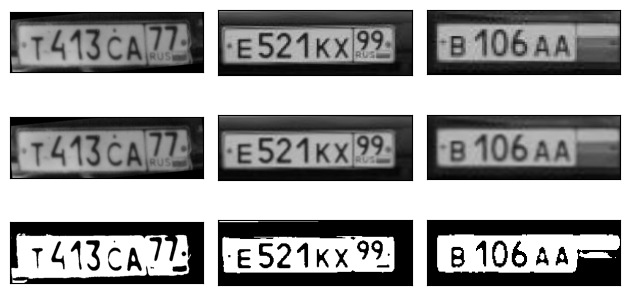

In [171]:
images = [rotated_plate_0, rotated_plate_1, rotated_plate_2,
          rotated_plate_0_g, rotated_plate_1_g, rotated_plate_2_g,
          rotated_plate_0_g_thresh, rotated_plate_1_g_thresh, rotated_plate_2_g_thresh]
for i in range(len(images)):
    plt.subplot(3, 3, i + 1), plt.imshow(images[i], 'gray')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
plt.tight_layout()
plt.show()

In [82]:
def PlateZoom(image):
    carplate_overlay = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
    carplate_rects = rusPlateFinder.detectMultiScale(carplate_overlay,
                                                     scaleFactor = 1.1,
                                                     minNeighbors = 5)
    if len(carplate_rects) < 2:
        for x, y, w, h in carplate_rects:
            carplate_img = carplate_overlay[y + 15: y + h - 10,
                                x + 15: x + w - 20]
    else:
        for i in range(0, len(carplate_rects)):
            carplate_rects_stage = carplate_rects[i]
            SemiZoom(carplate_rects_stage, carplate_overlay)
        exit
    return carplate_img

# Plot Results

In [7]:
plates = CarplateDetect(gray[0])
plateszoom = carplate_extract(gray[0])

In [25]:
carplate_rects = rusPlateFinder.detectMultiScale(gray[1],scaleFactor=1.1, minNeighbors=5) 

In [13]:
# cv2.imshow("test", plates)
cv2.imshow("test", plateszoom)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
for i in range(len(source)):
    plates[i] = CarplateDetect(gray[i])
    # plateszoom[i] = carplate_extract(gray[i])

images = [plates[0], plates[1], plates[2],
          plateszoom[0], plateszoom[1], plateszoom[2]]

In [ ]:
for i in range(3):
    plt.subplot(3, 2, i + 1), plt.imshow(plates[i], 'gray')
    plt.xticks([]), plt.yticks([])
    # plt.title(titles[i])
    plt.tight_layout()
# plt.suptitle('Edge Detection Results', fontsize = 25).set_color('#171819')
plt.tight_layout()
plt.show()